# Описание проекта

Исследование заказано в рамках исполнения обязанностей маркетингового аналитика развлекательного приложения Procrastinate Pro+. 

**Цель исследования:** Определить, почему, несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Разобраться в причинах и помочь компании выйти в плюс.

**Задачи исследования:**:

- выяснить откуда приходят пользователи и какими устройствами они пользуются,
- определить сколько стоит привлечение пользователей из различных рекламных каналов;
- определить сколько денег приносит каждый клиент,
- определить когда расходы на привлечение клиента окупаются,
- определить какие факторы мешают привлечению клиентов.

В ходе исследования будут использоваться предоставленные данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

**Ход исследования:** 
- Шаг 1. Загрузка и обработка данных 
- Шаг 2. Написание функции для расчёта и анализа LTV, ROI, удержания и конверсии.
- Шаг 3. Исследовательский анализ данных
- Шаг 4. Маркетинг
- Шаг 5. Оценка окупаемости рекламы
- Шаг 6. Вывод

### Загрузите данные и подготовьте их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

**Импортируем основные библиотеки**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

In [2]:
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),  # журнал сессий
    pd.read_csv('/datasets/orders_info_short.csv'),  # покупки
    pd.read_csv('/datasets/costs_info_short.csv') # траты на рекламу
)

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
visits = visits.drop_duplicates().reset_index(drop=True)

In [5]:
visits = visits.rename(columns={'User Id': 'user_id', 'Region': 'region', 'Device': 'device', 'Channel': 'channel', 
                                'Session Start': 'session_start', 'Session End': 'session_end',})

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [7]:
orders = orders.drop_duplicates().reset_index(drop=True)

In [8]:
orders = orders.rename(columns={'User Id': 'user_id', 'Event Dt': 'event_dt', 'Revenue': 'revenue',})

In [9]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [10]:
costs = costs.drop_duplicates().reset_index(drop=True)

In [11]:
costs = costs.rename(columns={'Channel': 'channel'})

In [12]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

**Вывод**

Качество данных является удовлетворительным. Пустых значений и дубликатов не обнаружено. 

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [13]:
# функция для создания пользовательских профилей

def get_profiles(visits, orders, costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [14]:
# функция для расчёта удержания

def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [15]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [16]:
def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
        
        
        
        
# функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )         

In [17]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [18]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [19]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [20]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

#### Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей

In [21]:
profiles = get_profiles(visits, orders, costs)

In [22]:
profiles

user_id            first_ts       channel  device         region  \
0             599326 2019-05-07 20:58:57      FaceBoom     Mac  United States   
1            4919697 2019-07-09 12:46:07      FaceBoom  iPhone  United States   
2            6085896 2019-10-01 09:58:33       organic  iPhone         France   
3           22593348 2019-08-22 21:35:48    AdNonSense      PC        Germany   
4           31989216 2019-10-02 00:07:44       YRabbit  iPhone  United States   
...              ...                 ...           ...     ...            ...   
150003  999956196527 2019-09-28 08:33:02        TipTop  iPhone  United States   
150004  999975439887 2019-10-21 00:35:17       organic      PC             UK   
150005  999976332130 2019-07-23 02:57:06        TipTop  iPhone  United States   
150006  999979924135 2019-09-28 21:28:09  MediaTornado      PC  United States   
150007  999999563947 2019-10-18 19:57:25       organic  iPhone  United States   

                dt      month  payer  acquisition_cost  
0       2019-05-07 2019-05-01   True          1.088172  
1       2019-07-09 2019-07-01  False          1.107237  
2       2019-10-01 2019-10-01  False          0.000000  
3       2019-08-22 2019-08-01  False          0.988235  
4       2019-10-02 2019-10-01  False          0.230769  
...            ...        ...    ...               ...  
150003  2019-09-28 2019-09-01  False          3.500000  
150004  2019-10-21 2019-10-01  False          0.000000  
150005  2019-07-23 2019-07-01  False          2.600000  
150006  2019-09-28 2019-09-01  False          0.205714  
150007  2019-10-18 2019-10-01  False          0.000000  

[150008 rows x 9 columns]

In [23]:
print(f'Минимальная дата привлечения:', profiles['dt'].min())
print(f'Максимальная дата привлечения:', profiles['dt'].max())

Минимальная дата привлечения: 2019-05-01
Максимальная дата привлечения: 2019-10-27


**Вывод**

Данные соответствуют указанным в ТЗ (данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года).

#### Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [24]:
regions_new_users = profiles.groupby('region').agg({'user_id': 'nunique'}).sort_values(by = 'user_id', ascending = False)
regions_new_users['доля'] = round(regions_new_users['user_id'] / (sum(regions_new_users['user_id'])), 2)

display(regions_new_users)

user_id  доля
region                      
United States   100002  0.67
UK               17575  0.12
France           17450  0.12
Germany          14981  0.10

In [25]:
chain_regions_new_users = go.Figure(data=[go.Pie(labels = ['United States', 'UK','France', 'Germany'], values=regions_new_users['user_id'],
                             title='Из каких стран пользователи', pull = [0.1, 0])])
chain_regions_new_users.show()

In [26]:
regions_new_payers = profiles.query('payer == True').groupby('region').agg({'user_id': 'nunique'}).sort_values(by = 'user_id', ascending = False)

regions_new_payers['доля'] = round(regions_new_payers['user_id'] / (sum(regions_new_payers['user_id'])), 2)

display(regions_new_payers)

user_id  доля
region                      
United States     6902  0.78
UK                 700  0.08
France             663  0.07
Germany            616  0.07

In [27]:
chain_regions_new_payers = go.Figure(data=[go.Pie(labels = ['United States', 'UK','France', 'Germany'], values=regions_new_payers['user_id'],
                             title='Соотношение платящих пользователей из разных стран', pull = [0.1, 0])])
chain_regions_new_payers.show() 

**Вывод 3.2.**

На США приходится наибольшее число пришедших пользователей (**66,7%**) и закономерно наибольшее число платящих пользователей (**77,7%**).

#### Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [28]:
devices_new_users = profiles.groupby('device').agg({'user_id': 'nunique'}).sort_values(by = 'user_id', ascending = False)
devices_new_users['доля'] = round(devices_new_users['user_id'] / (sum(devices_new_users['user_id'])), 2)

display(devices_new_users)

user_id  доля
device                
iPhone     54479  0.36
Android    35032  0.23
PC         30455  0.20
Mac        30042  0.20

In [29]:
chain_devices_new_users = go.Figure(data=[go.Pie(labels = ['iPhone', 'Android','PC', 'Mac'], values=devices_new_users['user_id'],
                             title='Какими устройствами пользуются клиенты', pull = [0.1, 0])])
chain_devices_new_users.show()

In [30]:
devices_new_payers = profiles.query('payer == True').groupby('device').agg({'user_id': 'nunique'}).sort_values(by = 'user_id', ascending = False)

devices_new_payers['доля'] = round(devices_new_payers['user_id'] / (sum(devices_new_payers['user_id'])), 2)

display(devices_new_payers)

user_id  доля
device                
iPhone      3382  0.38
Android     2050  0.23
Mac         1912  0.22
PC          1537  0.17

In [31]:
chain_devices_new_payers = go.Figure(data=[go.Pie(labels = ['iPhone', 'Android','Mac', 'PC'], values=devices_new_payers['user_id'],
                             title='Соотношение платящих пользователей по разным устройствам', pull = [0.1, 0])])
chain_devices_new_payers.show() 

**Вывод 3.3.**

На iPhone приходится наибольшее число пришедших пользователей (**36,3%**) и закономерно наибольшее число платящих пользователей (**38,1%**). Преобладание платящих пользователей, пользующихся девайсами американских производителей (iPhone и высокое значение платящих пользователей Mac) объясняется результатами пункта **3.2.** - преобладание платящих пользователей из США.

#### Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения

In [32]:
channels_new_users = profiles.groupby('channel').agg({'user_id': 'nunique'}).sort_values(by = 'user_id', ascending = False)
channels_new_users['доля'] = round(channels_new_users['user_id'] / (sum(channels_new_users['user_id'])), 2)

display(channels_new_users)

user_id  доля
channel                          
organic               56439  0.38
FaceBoom              29144  0.19
TipTop                19561  0.13
OppleCreativeMedia     8605  0.06
LeapBob                8553  0.06
WahooNetBanner         8553  0.06
RocketSuperAds         4448  0.03
MediaTornado           4364  0.03
YRabbit                4312  0.03
AdNonSense             3880  0.03
lambdaMediaAds         2149  0.01

In [33]:
chain_channels_new_users = go.Figure(data=[go.Pie(labels = ['organic', 'FaceBoom','TipTop','OppleCreativeMedia','LeapBob',
                                                           'WahooNetBanner', 'RocketSuperAds', 'MediaTornado',
                                                           'YRabbit', 'AdNonSense', 'lambdaMediaAds'], values=channels_new_users['user_id'],
                             title='Из каких каналов пришли клиенты', pull = [0.1, 0])])
chain_channels_new_users.show()

In [34]:
channels_new_payers = profiles.query('payer == True').groupby('channel').agg({'user_id': 'nunique'}).sort_values(by = 'user_id', ascending = False)

channels_new_payers['доля'] = round(channels_new_payers['user_id'] / (sum(channels_new_payers['user_id'])), 2)

display(channels_new_payers)

user_id  доля
channel                          
FaceBoom               3557  0.40
TipTop                 1878  0.21
organic                1160  0.13
WahooNetBanner          453  0.05
AdNonSense              440  0.05
RocketSuperAds          352  0.04
LeapBob                 262  0.03
OppleCreativeMedia      233  0.03
lambdaMediaAds          225  0.03
YRabbit                 165  0.02
MediaTornado            156  0.02

In [35]:
chain_channels_new_payers = go.Figure(data=[go.Pie(labels = ['FaceBoom','TipTop','organic','WahooNetBanner',
                                                             'AdNonSense','RocketSuperAds','LeapBob',
                                                             'OppleCreativeMedia','lambdaMediaAds','YRabbit',
                                                             'MediaTornado'], values=channels_new_payers['user_id'],
                             title='Соотношение платящих пользователей по разным каналам привлечения', pull = [0.1, 0])])
chain_channels_new_payers.show() 

**Вывод 3.4.**

На Органический трафик приходится наибольшее число пришедших пользователей (**37,6%**), при этом основное число платящих пользователей приходит не на органический трафик (**всего лишь 13,1%**), а на платформы FaceBoom (**40,1%**) и TipTop (**21,1%**).

**Доля платящих пользователей для страны**

In [36]:
regions_new_payers['доля от всех пользователей данного сегмента'] = round(regions_new_payers['user_id']/ regions_new_users['user_id'],2)
regions_new_payers = regions_new_payers.drop(columns = ['user_id', 'доля'],
                                             axis = 1).sort_values(by = 'доля от всех пользователей данного сегмента',
                                                                                                ascending = False)
regions_new_payers

доля от всех пользователей данного сегмента
region                                                    
United States                                         0.07
UK                                                    0.04
France                                                0.04
Germany                                               0.04

**Доля платящих пользователей для устройства**

In [37]:
devices_new_payers['доля от всех пользователей данного сегмента'] = round(devices_new_payers['user_id']/ devices_new_users['user_id'],2)
devices_new_payers = devices_new_payers.drop(columns = ['user_id', 'доля'],
                                             axis = 1).sort_values(by = 'доля от всех пользователей данного сегмента',
                                                                                                ascending = False)
devices_new_payers

доля от всех пользователей данного сегмента
device                                              
iPhone                                          0.06
Android                                         0.06
Mac                                             0.06
PC                                              0.05

**Доля платящих пользователей для канала продвижения**

In [38]:
channels_new_payers['доля от всех пользователей данного сегмента'] = round(channels_new_payers['user_id']/ channels_new_users['user_id'],2)
channels_new_payers = channels_new_payers.drop(columns = ['user_id', 'доля'],
                                               axis = 1).sort_values(by = 'доля от всех пользователей данного сегмента',
                                                                                                  ascending = False)
channels_new_payers

доля от всех пользователей данного сегмента
channel                                                        
FaceBoom                                                   0.12
AdNonSense                                                 0.11
TipTop                                                     0.10
lambdaMediaAds                                             0.10
RocketSuperAds                                             0.08
WahooNetBanner                                             0.05
YRabbit                                                    0.04
MediaTornado                                               0.04
LeapBob                                                    0.03
OppleCreativeMedia                                         0.03
organic                                                    0.02

**Вывод по разделу 3**

- Данные соответствуют указанным в ТЗ (данные о пользователях, привлечённых **с 1 мая по 27 октября 2019 года**).
- На США приходится наибольшее число пришедших пользователей (**66,7%**) и закономерно наибольшее число платящих пользователей среди всех платящих пользователей приложения (**77,7%**).
- На iPhone приходится наибольшее число пришедших пользователей (**36,3%**) и наибольшее число платящих пользователей среди всех платящих пользователей приложения (**38,1%**). Преобладание платящих пользователей, пользующихся девайсами американских производителей (iPhone и высокое значение платящих пользователей Mac) объясняется результатами пункта **3.2.** - преобладание платящих пользователей из США.
- На Органический трафик приходится наибольшее число пришедших пользователей (**37,6%**), при этом основная доля среди всех платящих пользователей приходится не на органический трафик (**всего лишь 13,1%**), а на платформы FaceBoom (**40,1%**) и TipTop (**21,1%**).
- Наибольшая доля платящих пользователей в рамках отдельного сегмента по стране приходится на США. Практически каждый седьмой привлеченной в приложение американский пользователь совершил покупку в приложении. В других странах доля платящих пользователей в рамках отдельного сегмента по стране составляет **0.04**.
- Доли платящих пользователей в рамках отдельного сегмента по типу устройства распределены равномерно среди 4 представленных в данных типов устройств. 
- Наибольшая доля платящих пользователей в рамках отдельного сегмента по каналу продвижения приходится на FaceBoom (**0.12**), AdNonSense (**0.11**), TipTop (**0.10**), lambdaMediaAds (**0.10**). Практически каждый десятый пользователь, привлеченный через эти каналы совершил минимум одну покупку в приложении.

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

#### Посчитайте общую сумму расходов на маркетинг.

In [39]:
print(f'Общая сумма расходов на маркетинг составила:', round(sum(profiles['acquisition_cost']),2), f'долларов')

Общая сумма расходов на маркетинг составила: 105497.3 долларов


#### Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [40]:
cost_channels = profiles.query('acquisition_cost > 0').groupby('channel').agg({'acquisition_cost': 'sum'}).sort_values(by = 'acquisition_cost', ascending = False)

cost_channels['доля'] = round(cost_channels['acquisition_cost'] / (sum(cost_channels['acquisition_cost'])), 2)

display(cost_channels)

acquisition_cost  доля
channel                                   
TipTop                      54751.30  0.52
FaceBoom                    32445.60  0.31
WahooNetBanner               5151.00  0.05
AdNonSense                   3911.25  0.04
OppleCreativeMedia           2151.25  0.02
RocketSuperAds               1833.00  0.02
LeapBob                      1797.60  0.02
lambdaMediaAds               1557.60  0.01
MediaTornado                  954.48  0.01
YRabbit                       944.22  0.01

**Вывод 4.2.**

Больше всего средств ушло на продвижение на платформах TipTop (**52%**) и FaceBoom (**31%**). При этом результаты **3.3**, **3.4** показывают, что новые пользователи и платящие пользователи преимущественно переходили из FaceBoom (**40,1%**), а не из TipTop (**21,1%**).

#### Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.

In [41]:
profiles['date'] = pd.to_datetime(profiles['first_ts'])
profiles['week'] = profiles['first_ts'].dt.isocalendar().week
profiles['month'] = profiles['first_ts'].dt.month

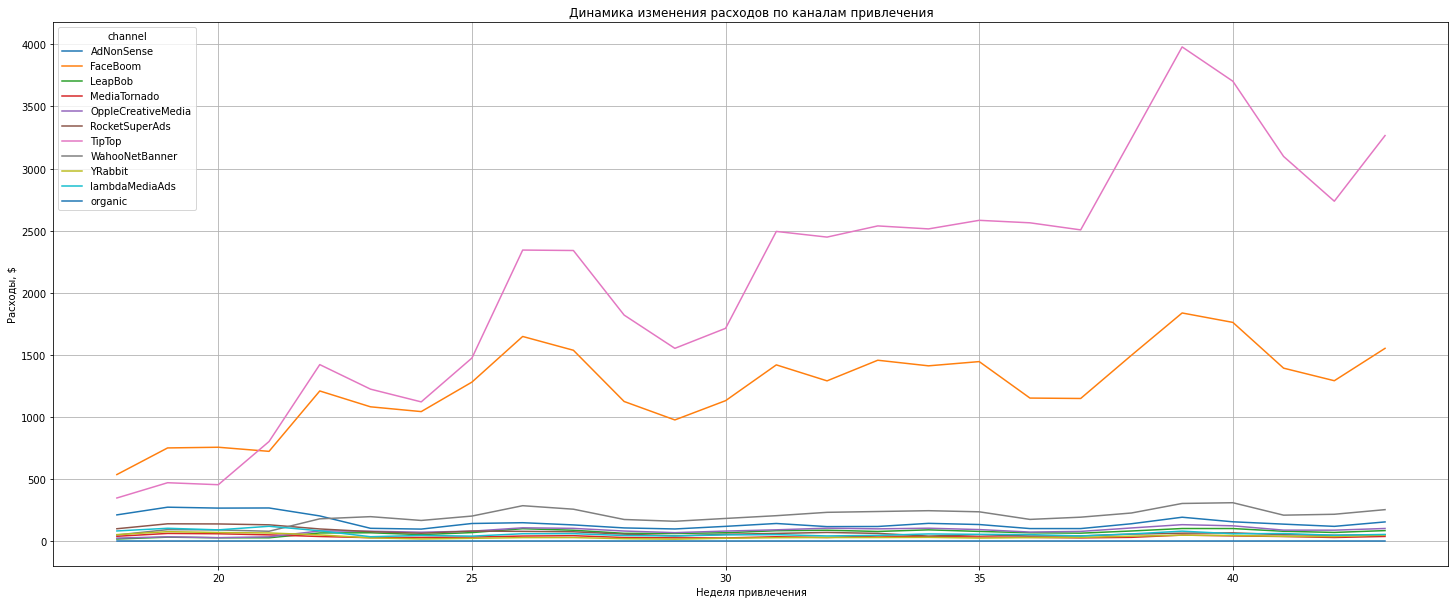

In [42]:
# строим график истории изменений расходов по каналам привлечения по неделям

profiles.pivot_table(
    index='week', columns='channel', values='acquisition_cost', aggfunc='sum'
).plot(grid=True, figsize=(25, 10))
plt.ylabel('Расходы, $')
plt.xlabel('Неделя привлечения')
plt.title('Динамика изменения расходов по каналам привлечения')
plt.show()

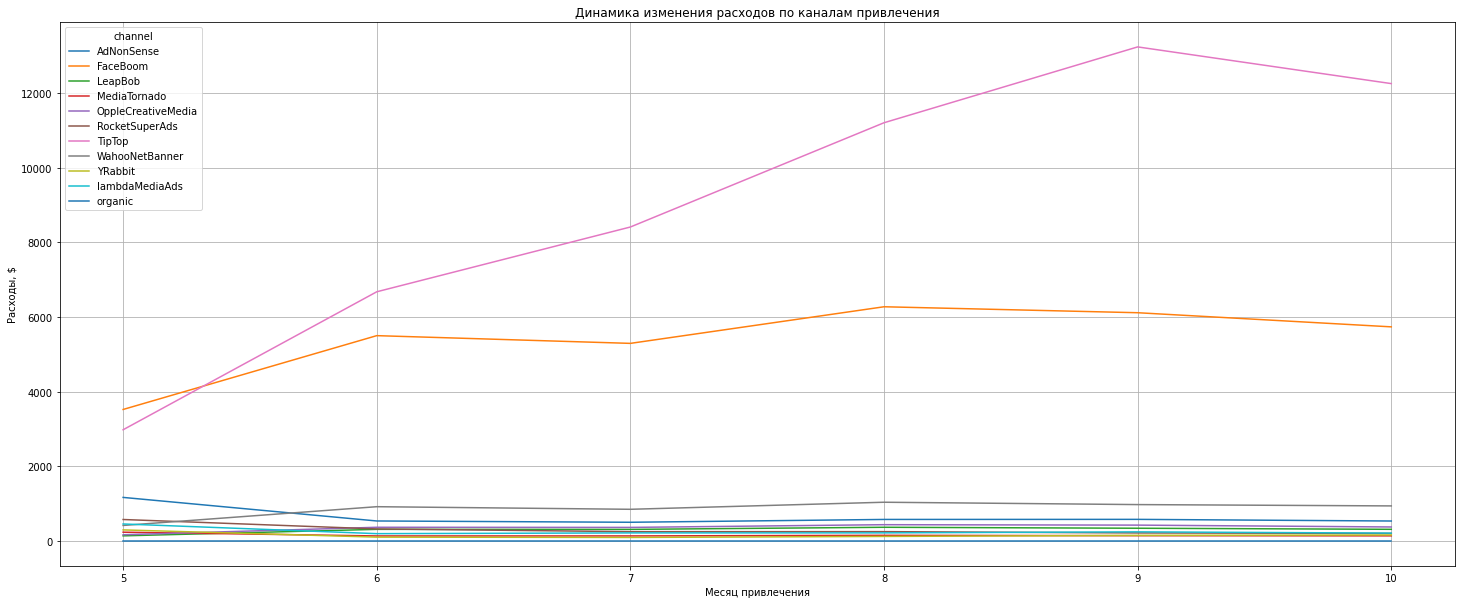

In [43]:
# строим график истории изменений расходов по каналам привлечения по месяцам

profiles.pivot_table(
    index='month', columns='channel', values='acquisition_cost', aggfunc='sum'
).plot(grid=True, figsize=(25, 10))
plt.ylabel('Расходы, $')
plt.xlabel('Месяц привлечения')
plt.title('Динамика изменения расходов по каналам привлечения')
plt.show()

#### Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника

In [44]:
# строим график истории изменений CAC по каналам привлечения

cac_channels = profiles.pivot_table(
    index='channel', values='acquisition_cost', aggfunc='mean').sort_values(by = 'acquisition_cost', ascending = False)

cac_channels = round(cac_channels['acquisition_cost'],1)

display(cac_channels)

channels = ['TipTop', 'FaceBoom','AdNonSense','lambdaMediaAds', 'WahooNetBanner', 'RocketSuperAds', 
            'OppleCreativeMedia','YRabbit', 'MediaTornado', 'LeapBob', 'organic']                                                            

fig_cac_channels = px.bar(cac_channels, x=channels, y='acquisition_cost', 
                                 title='CAC из каждого источника', color=channels)


fig_cac_channels.update_xaxes(tickangle=45)

fig_cac_channels.show() 

channel
TipTop                2.8
FaceBoom              1.1
AdNonSense            1.0
lambdaMediaAds        0.7
WahooNetBanner        0.6
RocketSuperAds        0.4
OppleCreativeMedia    0.2
YRabbit               0.2
MediaTornado          0.2
LeapBob               0.2
organic               0.0
Name: acquisition_cost, dtype: float64

**Вывод 4.4.**

Больше всего привлечение одного пользователя (CAC) стоило на платформе TipTop (**2.8**), что практически в три раза дороже, чем привлечение через FaceBoom (**1.1**). 

**Вывод по разделу 4**

- Общая сумма расходов на маркетинг составила: 105497.3 долларов.
- Больше всего средств ушло на продвижение на платформах TipTop (**52%**) и FaceBoom (**31%**). При этом результаты **3.3**, **3.4** показывают, что новые пользователи и платящие пользователи преимущественно переходили из FaceBoom (**40,1%**), а не из TipTop (**21,1%**).
- С начала мая больше всего расходо шло на продвижение через платформы TipTop и FaceBoom. С мая наблюдается рост расходов на продвижение через TipTop.
- Больше всего привлечение одного пользователя (CAC) стоило на платформе TipTop (**2.8**), что практически в три раза дороже, чем привлечение через FaceBoom (**1.1**). 


### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

#### Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [45]:
profiles = profiles.query('channel != "organic"')
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

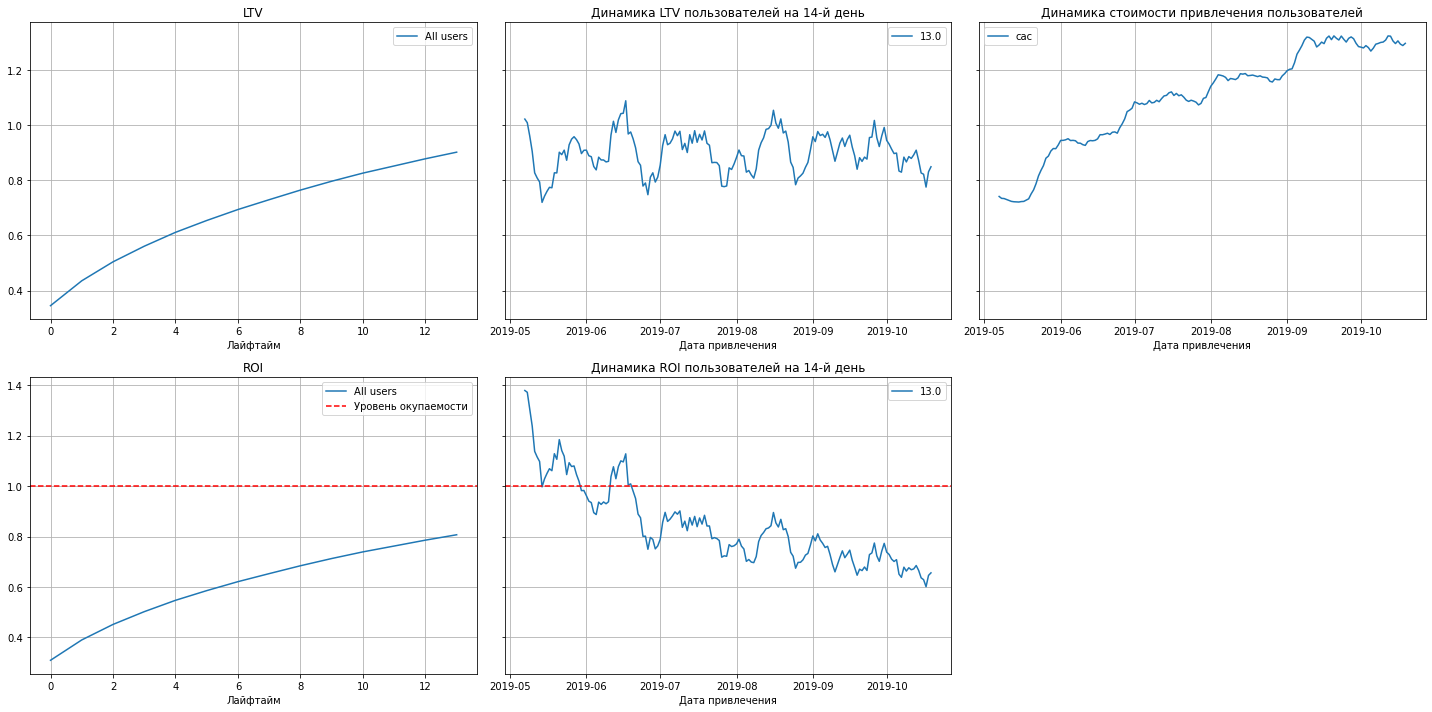

In [46]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Вывод 5.1.**

По графикам можно сделать следующие выводы:
- CAC совершил резкий рост в середине мая и продолжал постепенный рост. 
- Динамика LTV показывала рост до середины июня, но потом начались циклические колебания. При этом расходы на маркетинг продолжали расти. 
- Реклама не окупается, если отбросить органический трафик. ROI в конце горизонта двух недель составляет около 80%.
- Динамика ROI демонстрирует, что с одновременным ростом CAC началось падение ROI. C конца июня ROI стал меньше уровня окупаемости. 

#### Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.

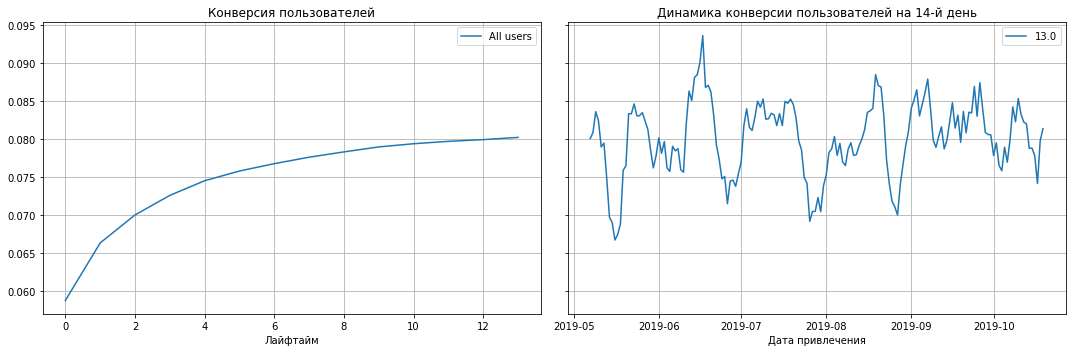

In [47]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

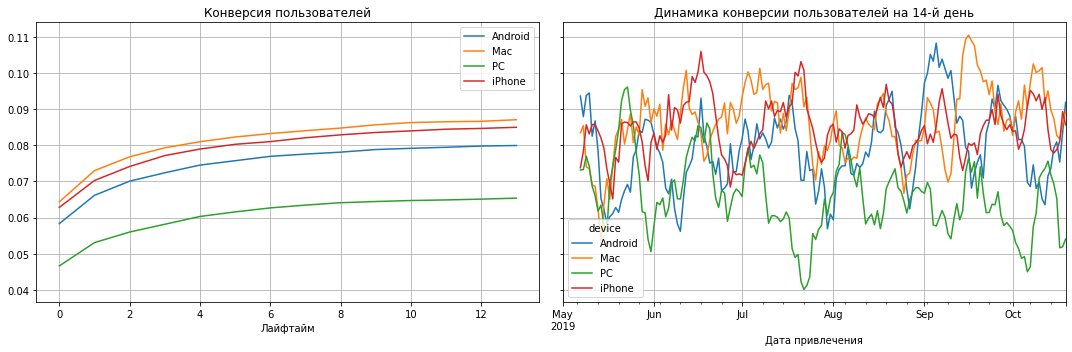

In [48]:
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days,dimensions = dimensions )

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

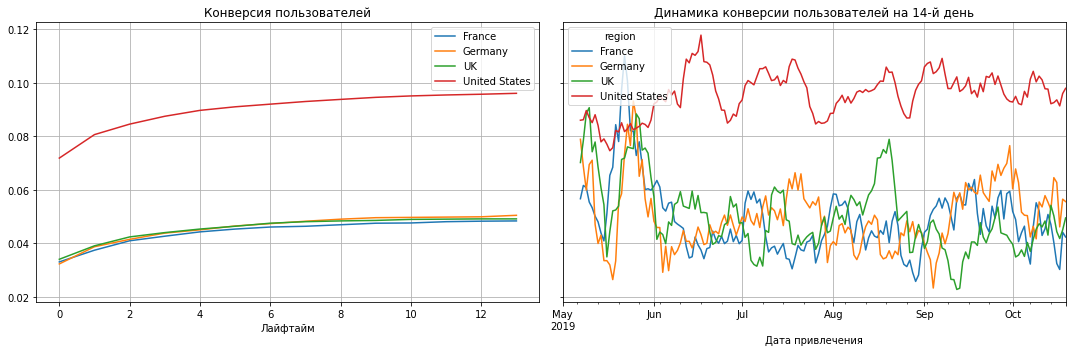

In [49]:
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days,dimensions = dimensions )

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

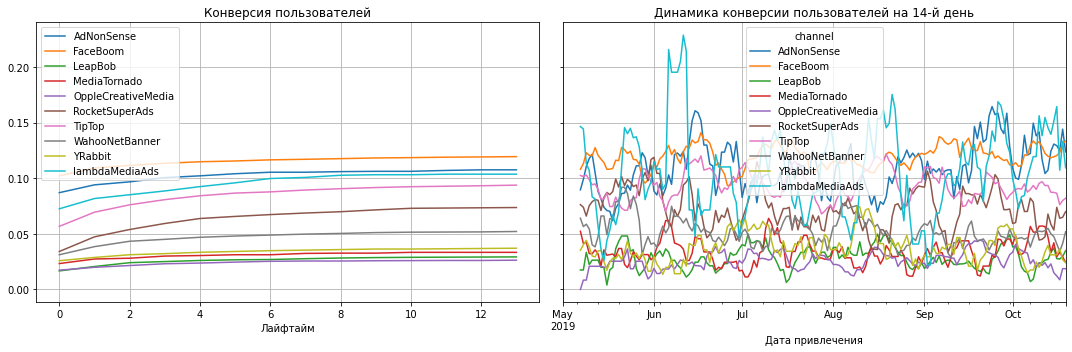

In [50]:
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days,dimensions = dimensions )

plot_conversion(conversion_grouped, conversion_history, horizon_days)

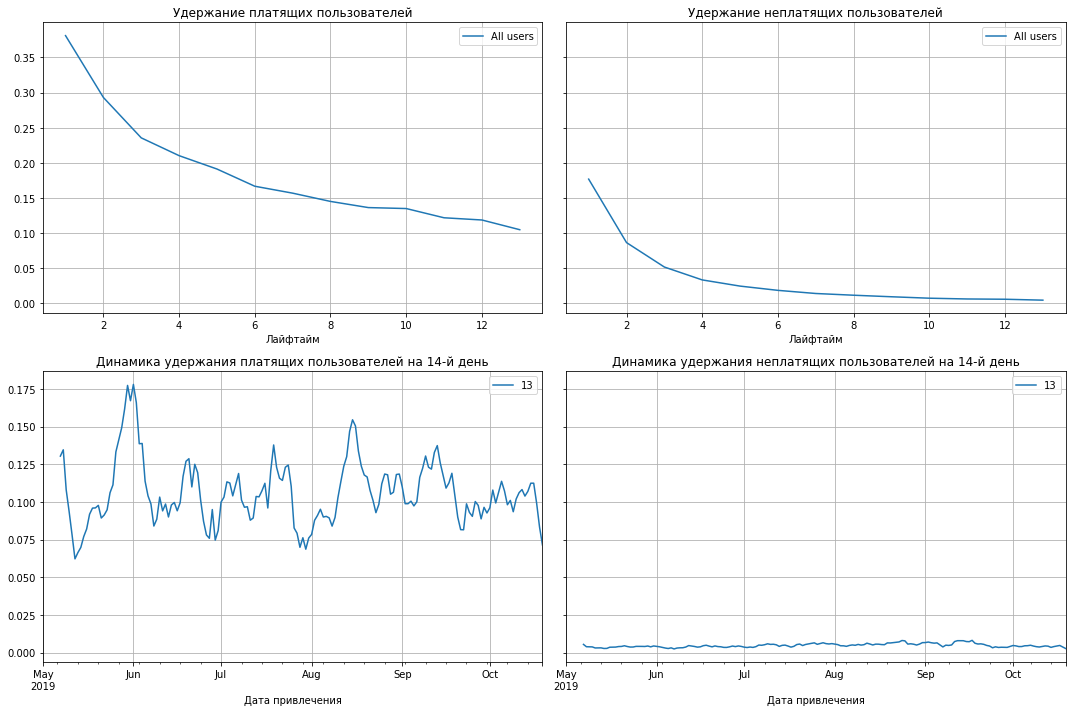

In [51]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days)

plot_retention(retention_grouped, retention_history, horizon_days) 

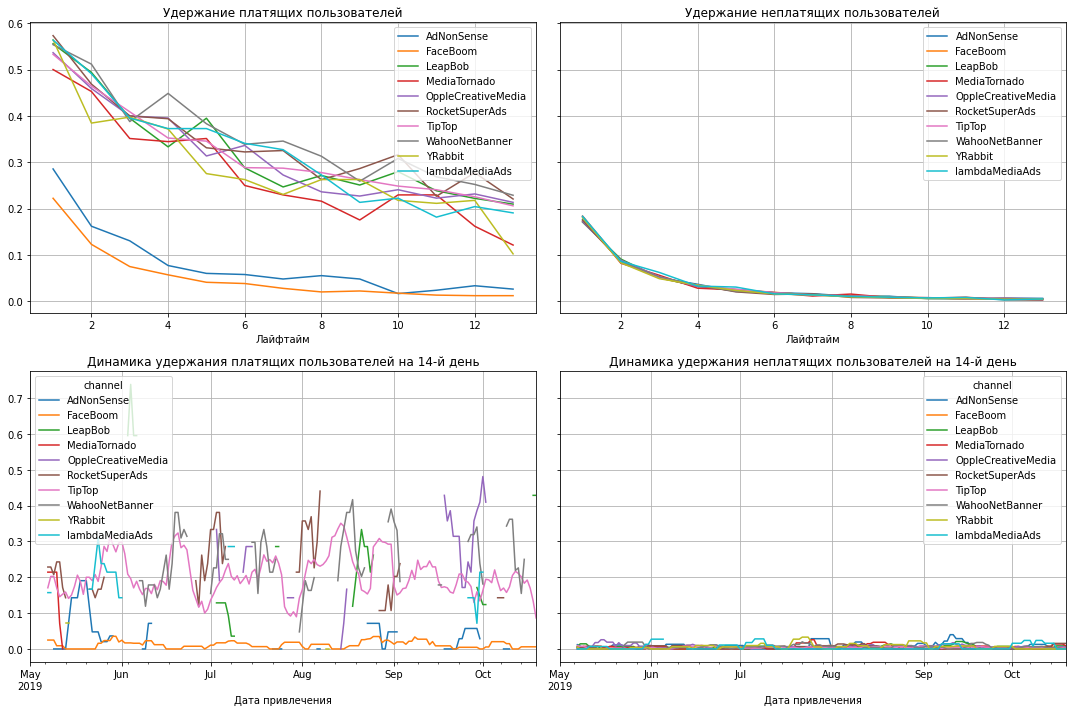

In [52]:
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = dimensions)

plot_retention(retention_grouped, retention_history, horizon_days) 

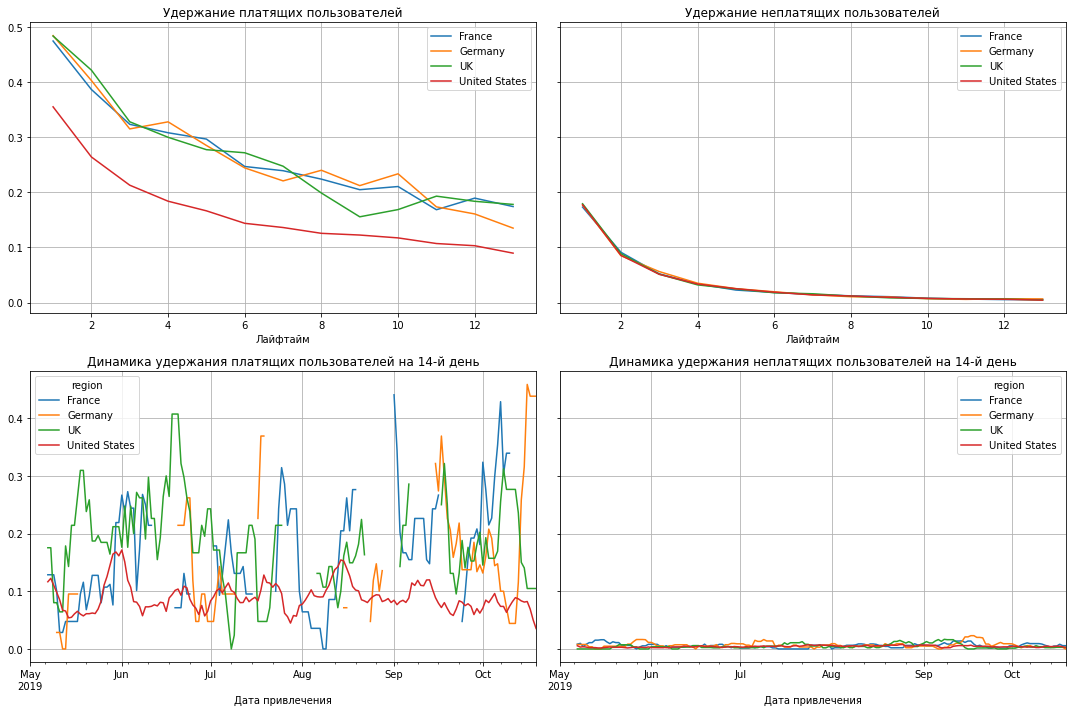

In [53]:
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = dimensions)

plot_retention(retention_grouped, retention_history, horizon_days) 

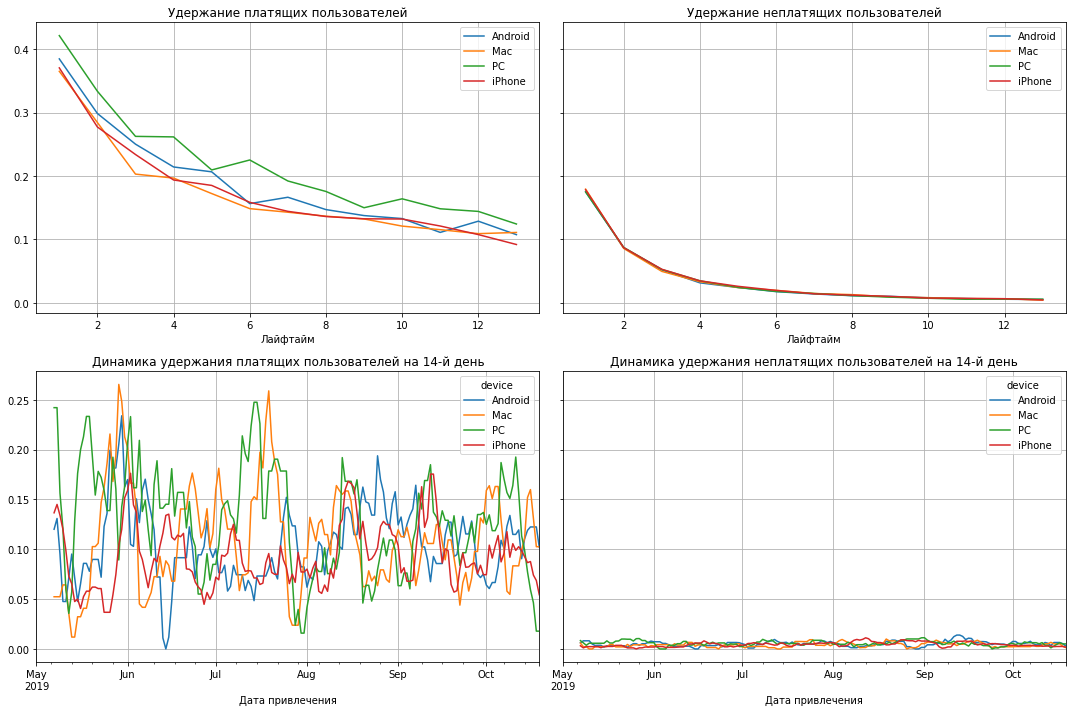

In [54]:
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = dimensions)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод 5.2.**

- Самая слабая конверсия у пользователей ПК. Самая сильная - пользователи iPhone и Mac.
- Самая сильная конверсия у пользователей из США. В остальных странах она идентичная.
- Самая сильная конверсия у пользователей, привлеченных через FaceBoom. Конверсия пользователей через платформу TipTop ниже.
- Абсолютно низкое удержание платящих пользователей, привлеченных через FaceBoom.
- Слабое удержание платящих пользователей из США.
- Одинаковое удержание у пользователей с различными типами устройств.

#### Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

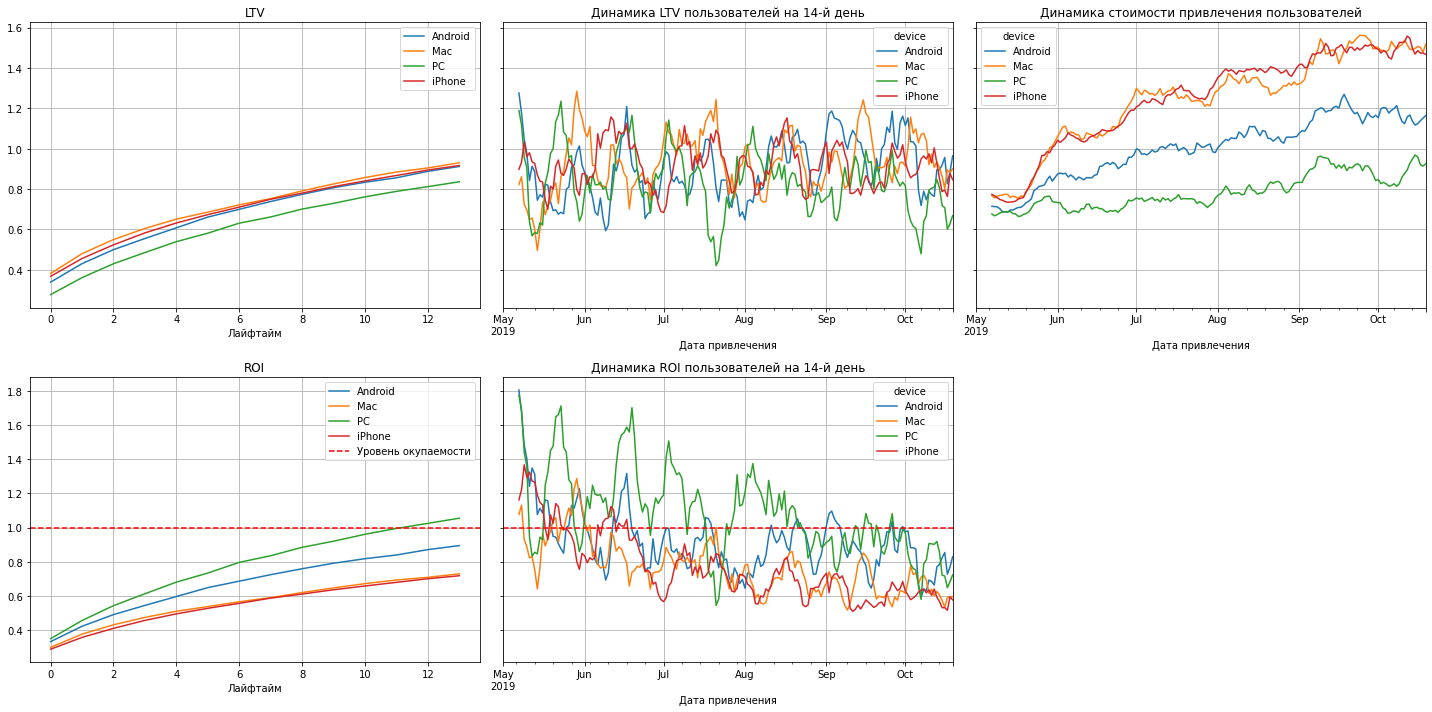

In [55]:
dimensions = ['device']

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions = dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Вывод 5.3.**

- Наибольший CAC приходится на iPhone и Mac.  
- LTV пользователей PC ниже остальных. При этом из-за низкого CAC инвестиции в рекламу для привлечения пользователей PC окупаются, пользователей Android не окупаютя, но приближается к уровню окупаемости, а для привлечения пользователей iPhone и Mac нет.

#### Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

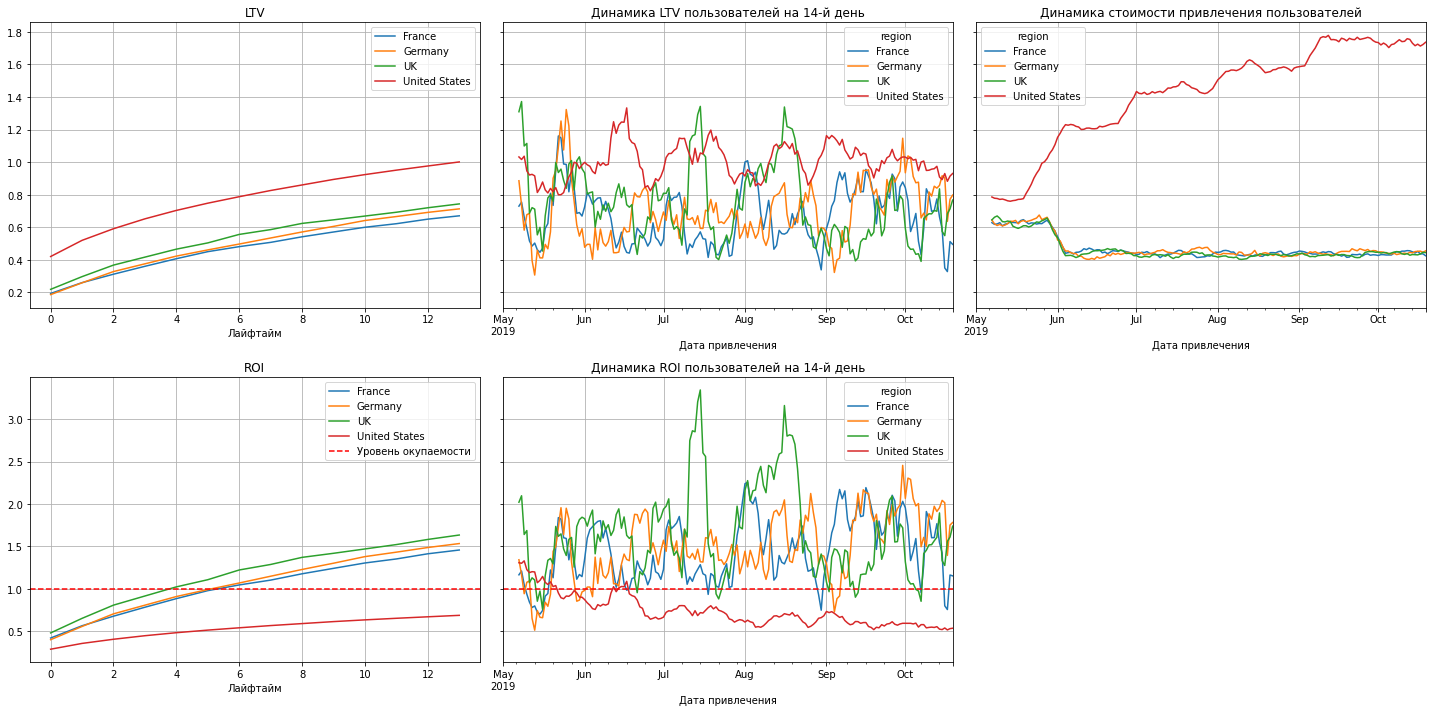

In [56]:
dimensions = ['region']

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions = dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Вывод 5.4.**

- Наибольший LTV приходится на США.
- Высокий CAC так же приходится на США.  
- Реклама во всех странах, кроме США, окупается за неделю. 
- ROI для пользователей из США до середины мая, когда произошел резкий рост CAC, был выше 100%. 

#### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

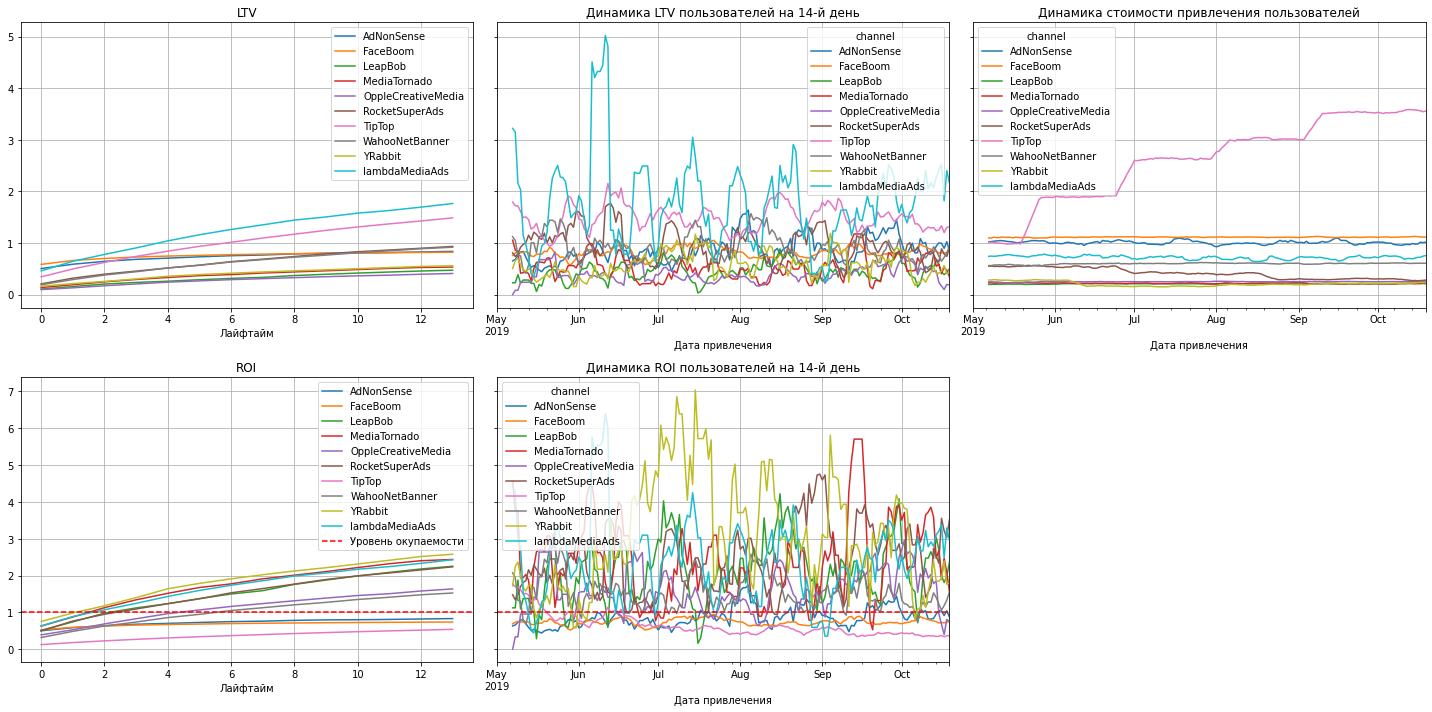

In [57]:
dimensions = ['channel']

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions = dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Вывод 5.5.**

- Наибольший LTV приходится на lambdMediaAds и TipTop.  
- С середины мая CAC через платформу TipTop стабильно рос. На других платформах CAC показывал стабильность.
- Реклама на всех платформах, кроме FaceBoom, AdNonSense и TipTop, окупается уже за неделю.  

#### Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

1. В целом общий ROI не окупается и составляет около 80%, но примечательно, что до начала июня и во время краткосрочного роста в середине июня  этот показатель был выше уровня окупаемости. Снижение ROI началось после резкого увеличения CAC в конце мая - начале июня.
2. Негативное влияние на окупаемость рекламы вызвало резкий рост CAC на привлечение американских пользователей, пользователей, пользующихся американскими девайсами (iPhone и Mac) и привлеченные через основную используемую в ходе маркетинговой кампании и наиболее дорогую по значению CAC платформу TipTop, а также плохо удерживающую платящих пользователей FaceBoom.
3. В первую очередь, проблема окупаемости связана с ростом CAC в середине мая 2019 года. Более половины рекламного бюджета было потрачено на продвижение через TipTop, платформу с показателем CAC в 2.8$

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

**Причины неэффективности:**
- Начало резкого роста CAC в середине мая 2019 года.
- Высокий уровень CAC через платформу TipTop, на которую ушло больше половины рекламного бюджета. При этом через TipTop в приложение перешло всего 13% от всего числа новых пользователей. Идентичный показатель FaceBoom составляет 19%. По платящим пользователям так же значение FaceBoom выше TipTop.
- Несмотря на то, что на FaceBoom приходится 40% платящих пользователей и у этой платформы высокая конверсия покупателей, у платформы низкое удержание пользователей, что приводит к тому, что расходы на привлчение в ней, как и в TipTop, абсолютно не окупаются.
- Высокая стоимость привлечения американских пользователей, которые составляют основную аудиторию.

**Возможные рекомендации:**
- Пересмотреть стратегию преимущественного использования платформ TipTop и FaceBoom, попробовать диверсифицировать платформы для увеличения числа уникальных платящих пользователей. Можно сделать вывод, что аудитория указанных платформ не подходит к аудитории, пользующейся нашим приложением.
- Увеличить маркетинговые расходы на продвижение через более дешевые платформы с высокой конверсией, показателем LTV и удержанием платящих пользователей. Отказаться от использования платформ с низким ROI и перенести акцент на платформы с наибольшим ROI. По показателю ROI наиболее выделяются платформы: Yrabbit, lambdaMediaAds, MediaTornado и RocketSuperAds. Например, хорошим вариантом является платформа lambdaMediaAds c высоким показателем конверсии, приемлемым удержанием платящих пользователей и, самое главное, самым высоким показателем LTV и низким показателем СAC.
- Сместить акцент от привлечения дорогих американских пользователей, чей более высокий LTV не позволяет перекрыть высокие расходы на их привлечение. Несмотря на то, что значение конверсии у американских пользователей больше, но более высокий уровень удержания и низкий CAC пользователей из других регионов приводит к тому, что в других регионах ROI выше уровня окупаемости.
- Сместить акцент от привлечения дорогих пользователей iPhone и Mac. Например, показатели LTV и ROI показывают, что реклама пользователям Android и PC более эффективная.